In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os

# set the random seed
seed = 314
tf.random.set_seed(seed)
np.random.seed(seed)

train_path = 'D:/Yoga Poses Dataset/TRAIN/'
test_path = 'D:/Yoga Poses Dataset/TEST/'

c:\Users\Oishi\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Oishi\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
c:\Users\Oishi\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
class_names = []
train_distrib = []
test_distrib = []

# for train
for dir in os.listdir(train_path):
    class_names.append(dir) # append the folder name, the class
    number = len(os.listdir(train_path+dir+'/')) # count the files on the dir
    train_distrib.append(number) # append that number
    
# for test
for dir in os.listdir(test_path):
    #class_names.append(dir) # append the folder name, the class
    number = len(os.listdir(test_path+dir+'/')) # count the files on the dir
    test_distrib.append(number) # append that number

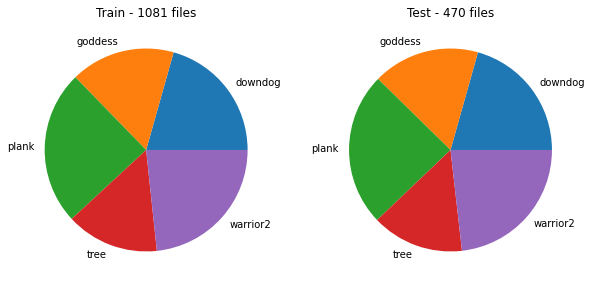

In [3]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.pie(train_distrib, labels=class_names)
plt.title(f'Train - {sum(train_distrib)} files')
plt.subplot(1,2,2)
plt.pie(test_distrib, labels=class_names)
plt.title(f'Test - {sum(test_distrib)} files')
plt.show()

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# instance and adjust the options
train_datagen = ImageDataGenerator(
    rescale = 1/255, # normalize the values
    shear_range = 0.2, # it means to cut the image
    zoom_range = 0.2, # make zoom
    horizontal_flip = True # invert horizontally
)

test_datagen = ImageDataGenerator(
    rescale = 1/ 255,
    horizontal_flip = True,
    validation_split=0.25, # this is going to be for val
)

In [5]:
image_size = 128

# and load the images
train_gen = train_datagen.flow_from_directory(
    train_path, # the data folder
    batch_size = 16,
    class_mode = 'categorical', # for multi class
    target_size = (image_size, image_size), # the image size
    shuffle = True,
    seed = 314
)

Found 1081 images belonging to 5 classes.


In [6]:
# test, and i will use some of these images for validation
test_gen = test_datagen.flow_from_directory(
    test_path, # the data folder
    batch_size = 16,
    class_mode = 'categorical', # for multi class
    target_size = (image_size, image_size), # the image size
    shuffle = True,
    seed = seed,
    subset='training', # since test will be bigger than val
)

Found 354 images belonging to 5 classes.


In [7]:
# now validation
val_gen = test_datagen.flow_from_directory(
    test_path, # the test folder
    batch_size = 16,
    class_mode = 'categorical', # for multi class
    target_size = (image_size, image_size), # the image size
    shuffle = True,
    seed = seed,
    subset='validation', # since test will be bigger than val
)

Found 116 images belonging to 5 classes.


In [8]:
from tensorflow.keras import Sequential, layers

num_classes = len(class_names)

model = Sequential([
    # the imput shape must be defined
    layers.InputLayer(input_shape=[image_size, image_size, 3]),

    layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3), # this layer turn off random neurons each step
    # it helps to improve the model and helps to prevent overfitting
    
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

# this will be some strict to prevent overfitting
early_stopping = EarlyStopping(
    min_delta=0.005, # min loss improve
    patience=5, # epochs for the stop
    restore_best_weights=True
)

from PIL import ImageFile
# ask PIL to be tolerant of files that are truncated (missing some file from the block) by changing a setting.
# if that option isn't enabled training will trow an error
ImageFile.LOAD_TRUNCATED_IMAGES = True

history = model.fit(
    train_gen,
    validation_data = val_gen,
    epochs = 25,
    callbacks = [early_stopping]
)

Epoch 1/25
 2/68 [..............................] - ETA: 15s - loss: 1.6050 - accuracy: 0.2188 

c:\Users\Oishi\AppData\Local\Programs\Python\Python37\lib\site-packages\PIL\Image.py:952: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


68/68 [==============================] - 22s 315ms/step - loss: 1.5932 - accuracy: 0.2544 - val_loss: 1.3735 - val_accuracy: 0.5431
Epoch 2/25
68/68 [==============================] - 20s 287ms/step - loss: 1.3419 - accuracy: 0.4616 - val_loss: 0.6901 - val_accuracy: 0.7328
Epoch 3/25
68/68 [==============================] - 19s 284ms/step - loss: 1.1455 - accuracy: 0.5606 - val_loss: 0.7621 - val_accuracy: 0.7500
Epoch 4/25
68/68 [==============================] - 19s 280ms/step - loss: 0.9941 - accuracy: 0.6179 - val_loss: 0.5098 - val_accuracy: 0.8190
Epoch 5/25
68/68 [==============================] - 19s 281ms/step - loss: 0.9057 - accuracy: 0.6670 - val_loss: 0.4279 - val_accuracy: 0.8276
Epoch 6/25
68/68 [==============================] - 20s 288ms/step - loss: 0.7666 - accuracy: 0.7271 - val_loss: 0.2910 - val_accuracy: 0.9138
Epoch 7/25
68/68 [==============================] - 22s 318ms/step - loss: 0.6713 - accuracy: 0.7632 - val_loss: 0.2417 - val_accuracy: 0.9397
Epoch 8/25

In [11]:
results = model.evaluate(test_gen, batch_size=1)
print("test loss, test acc:", results)

16/23 [===================>..........] - ETA: 1s - loss: 0.3567 - accuracy: 0.8828

c:\Users\Oishi\AppData\Local\Programs\Python\Python37\lib\site-packages\PIL\TiffImagePlugin.py:771: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  "Possibly corrupt EXIF data.  "


23/23 [==============================] - 5s 240ms/step - loss: 0.3345 - accuracy: 0.9011
test loss, test acc: [0.33451640605926514, 0.901129961013794]


In [12]:
from sklearn.metrics import classification_report

# make predictions with the model and the test generator
y_pred = model.predict(test_gen)
# take the maximum number, as there are 5 numbers for each pred
y_pred = np.argmax(y_pred, axis=1)
# print the report
print(classification_report(test_gen.classes, y_pred))

17/23 [=====================>........] - ETA: 1s

c:\Users\Oishi\AppData\Local\Programs\Python\Python37\lib\site-packages\PIL\TiffImagePlugin.py:771: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  "Possibly corrupt EXIF data.  "


23/23 [==============================] - 6s 241ms/step
              precision    recall  f1-score   support

           0       0.19      0.19      0.19        73
           1       0.10      0.08      0.09        60
           2       0.18      0.17      0.18        87
           3       0.14      0.13      0.14        52
           4       0.22      0.26      0.24        82

    accuracy                           0.18       354
   macro avg       0.17      0.17      0.17       354
weighted avg       0.17      0.18      0.17       354



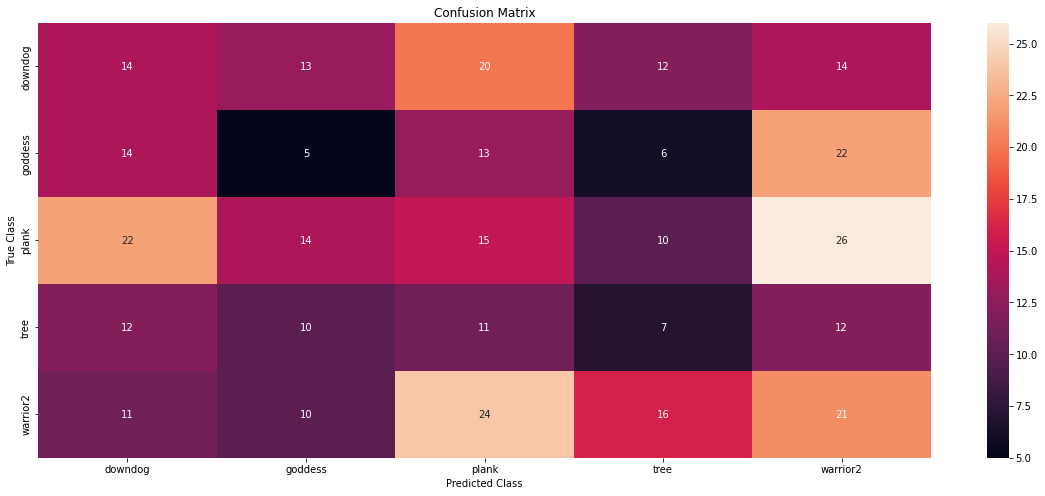

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# define the matrix with the real classes and the predicted
m = confusion_matrix(test_gen.classes, y_pred)
# the labels for the plot
labels = class_names
plt.figure(figsize=(20, 8))
# create the plot
heatmap = sns.heatmap(m, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', color='blue')
# labels for the axes
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

In [14]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

images = [] # path of the images
answers = [] # correct labels 

# 2 images per class

for clas in os.listdir(test_path):
    count = 0
    for image_path in os.listdir(test_path + clas + '/'):
        # append the image path
        images.append(test_path + clas + '/' + image_path)
        # append the answer
        answers.append(clas)
        count += 1 # count how many images have been appent
        if count == 2:
            break # only the two first ones

1/1 [==============================] - 0s 70ms/step
[1. 0. 0. 0. 0.]


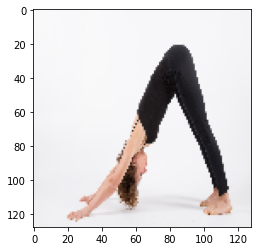

In [15]:
# load the image
image = load_img(images[0], target_size=(128, 128))
# copnvert to array
input_arr = img_to_array(image)
# convert as a batch for the model
input_arr = np.array([input_arr])  # Convert single image to a batch.
# and finally predict
prediction = model.predict(input_arr)
# squeeze because shape is (1,5)
print(np.squeeze(prediction))
plt.imshow(image)

In [16]:
# recive the prediction and returns the label
def list_to_label(ls):
    lis = np.squeeze(ls) # remove extra dimension
    lis = list(lis)
    index = lis.index(1) # look for the 1
    return class_names[index]

def read_image(path, size=128):
    # load the image
    image = load_img(path, target_size=(size, size))
    # copnvert to array
    input_arr = img_to_array(image)
    # convert as a batch for the model
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    # and finally predict
    # prediction = model.predict(input_arr)
    return image, input_arr

1/1 [==============================] - 0s 21ms/step


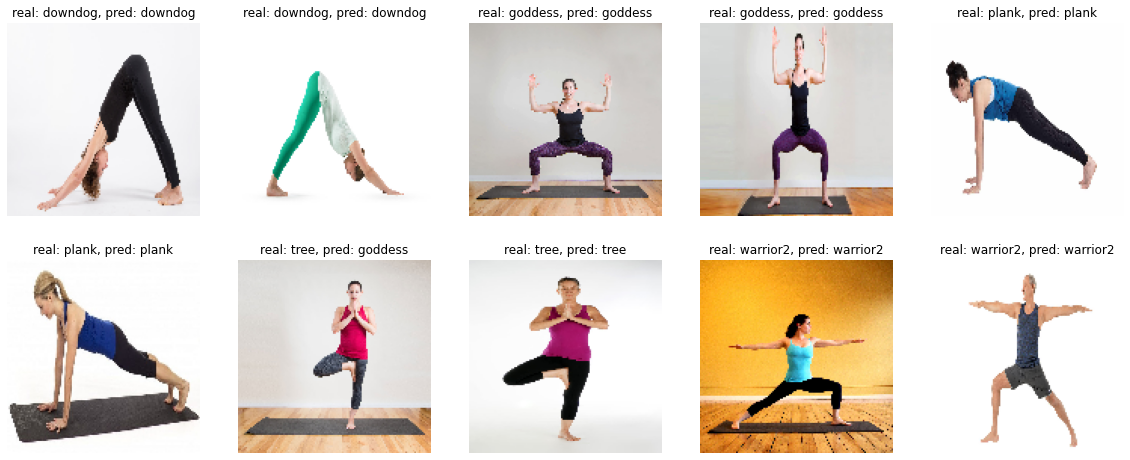

In [17]:
# plot the predictions
plt.figure(figsize=(20,8))

for img_path, ans, i in zip(images, answers, np.arange(10)):
    img, arr = read_image(img_path) # read the image
    pred = model.predict(arr) # predict
    plt.subplot(2,5,i+1) # set the plot position
    plt.imshow(img) # plot the image
    # set the title with the pred and the answer
    plt.title(f'real: {ans}, pred: {list_to_label(pred)}')
    plt.axis('off')

plt.show()

In [18]:
model.save('yoga_4class_cnn.h5')

1/1 [==============================] - 0s 73ms/step


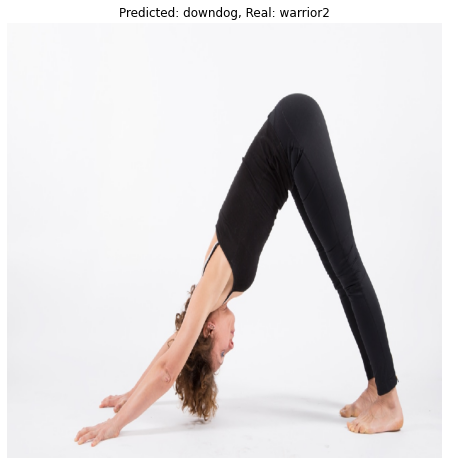

In [19]:
# this is how the model can be loaded
loaded_model = keras.models.load_model('./yoga_4class_cnn.h5')

# make one test prediction

# load an image
img, arr = read_image(images[0])
# an image with more quality for the end
hd_image, nothing = read_image(images[0], size=1024)
# predict
pred = loaded_model.predict(arr)
# show results
plt.figure(figsize=(8,8))
plt.imshow(hd_image)
plt.title(f'Predicted: {list_to_label(pred)}, Real: {ans}')
plt.axis('off')
plt.show()

In [20]:
import mediapipe as mp
import cv2
import time
import numpy as np
import pandas as pd
import os
mpPose = mp.solutions.pose
pose = mpPose.Pose()
mpDraw = mp.solutions.drawing_utils # For drawing keypoints
points = mpPose.PoseLandmark # Landmarks
path = "D:/Yoga Poses Dataset/TRAIN/plank" # enter dataset path
data = []
for p in points:
        x = str(p)[13:]
        data.append(x + "_x")
        data.append(x + "_y")
        data.append(x + "_z")
        data.append(x + "_vis")
data = pd.DataFrame(columns = data) # Empty dataset

In [21]:
from sklearn.svm import SVC

### In the above snippet of code, we have first imported the necessary libraries that will help in creating the dataset. Then in the next four lines, we are importing the modules required to extract key points and their draw utils. Next, we create an empty pandas data frame and enter the columns. Here the columns include the thirty-three key points that will be detected by the blaze pose detector. Each keypoint contains four attributes that are x and y coordinates of the keypoint(normalized from 0 to 1), z coordinate that represents landmark depth with hips as the origin and same scale as that of x, and lastly the visibility score. The visibility score represents the probability that the landmark is either visible in the image or not.

In [22]:
count = 0
for img in os.listdir(path):
        temp = []
        img = cv2.imread(path + "/" + img)
        imageWidth, imageHeight = img.shape[:2]
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        blackie = np.zeros(img.shape) # Blank image
        results = pose.process(imgRGB)
        if results.pose_landmarks:
                # mpDraw.draw_landmarks(img, results.pose_landmarks, mpPose.POSE_CONNECTIONS) #draw landmarks on image
                mpDraw.draw_landmarks(blackie, results.pose_landmarks, mpPose.POSE_CONNECTIONS) # draw landmarks on blackie
                landmarks = results.pose_landmarks.landmark
                for i,j in zip(points,landmarks):
                        temp = temp + [j.x, j.y, j.z, j.visibility]
                data.loc[count] = temp
                count +=1
        cv2.imshow("Image", img)
        cv2.imshow("blackie",blackie)
        cv2.waitKey(100)

data.to_csv("dataset3.csv") # save the data as a csv file

### In the above code, we are iterating through the pose images individually, extracting the key points using the blaze pose model and storing them in temporary array ‘temp’. After the iteration is completed, we append this temporary array as a new record in our dataset. You can also see these landmarks by using the drawing utils present in the media pipe itself. In the above code, I have drawn these landmarks on the image as well as on a blank image ‘blackie’ to focus on the results of the blaze pose model only. The blank image ‘blackie’ has the same shape as that of the given image. One thing that should be noticed is that the blaze pose model takes RGB images instead of BGR (read by OpenCV).

### After getting the key points of all the images we have to add a target value that will act as a label for our machine learning model. You can make the target value for 1st pose as 0 and the other as 1. After that, we can just save this data to a CSV file which we will use for creating a machine learning model in the later steps.

In [24]:
X,Y = data.iloc[:,:132],data['target']
model = SVC(kernel = 'poly')
model.fit(X,Y)
mpPose = mp.solutions.pose
pose = mpPose.Pose()
mpDraw = mp.solutions.drawing_utils
path = "enter image path"
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
results = pose.process(imgRGB)
if results.pose_landmarks:
        landmarks = results.pose_landmarks.landmark
        for j in landmarks:
                temp = temp + [j.x, j.y, j.z, j.visibility]
        y = model.predict([temp])
        if y == 0:
            asan = "plank"
        else:
            asan = "goddess"
        print(asan)
        cv2.putText(img, asan, (50,50), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,0),3)
        cv2.imshow("image",img)

KeyError: 'target'

### In the above lines of code, we have first imported the SVC (Support Vector Classifier) from the sklearn library. We have trained the dataset that we build earlier on SVC with the target variable as the Y label. Then we read the input image and extract the key points, the same way we did while creating the dataset. Lastly, we input the temporary variable and use the model to make the prediction. The pose can now be detected using simple if-else conditions.